In [1]:
import numpy as np
import dicom
import sys
sys.path.append('..')
import os
from AlgoEngine.utils import getVolume, getContours
from AlgoEngine.sts import getSTSHistogram
from math import sqrt
import time
import matplotlib.pyplot as plt

## Inputs to Function

In [2]:
BASE_DIR = '/home/radiation/RadiationTherapyDecisionSupport/data/'
PatientID = 'UCLA_PR_5'

ctFilenames = [fl for fl in os.listdir(BASE_DIR + PatientID) if 'CT.' in fl]
numImages = len(ctFilenames)

sampleCTImage = dicom.read_file(BASE_DIR + PatientID + '/' + ctFilenames[0])
width = sampleCTImage.Columns
height = sampleCTImage.Rows
row_spacing = float(sampleCTImage.PixelSpacing[0])
column_spacing = float(sampleCTImage.PixelSpacing[1])
slice_spacing = float(sampleCTImage.SliceThickness)

block_shape = (width, height, numImages)
slice_position_z = np.zeros((numImages)).astype(np.float32) 

for i, fl in enumerate(ctFilenames):
    slice_position_z[i] = dicom.read_file(BASE_DIR + PatientID + '/' + fl).ImagePositionPatient[2]

In [3]:
structureset = dicom.read_file(BASE_DIR + PatientID + '/structureset.dcm')
PTV_ROI_NUM = -1
OAR_ROI_NUM = -1

for n in range(0, len(structureset.StructureSetROISequence)):
    if structureset.StructureSetROISequence[n].ROIName == 'PTV':
        PTV_ROI_NUM = structureset.StructureSetROISequence[n].ROINumber
    elif structureset.StructureSetROISequence[n].ROIName == 'Bladder':
        OAR_ROI_NUM = structureset.StructureSetROISequence[n].ROINumber

In [4]:
roiNumPlanes = len(structureset.ROIContourSequence[PTV_ROI_NUM].ContourSequence) 

contour_data = {} 
image_orientation = {} 
image_position = {} 
pixel_spacing = {} 

for index in range(0, roiNumPlanes):
    
    imageSOP = structureset.ROIContourSequence[PTV_ROI_NUM].ContourSequence[index].ContourImageSequence[0].ReferencedSOPInstanceUID
    
    planeContourData = np.array(structureset.ROIContourSequence[PTV_ROI_NUM].ContourSequence[index].ContourData)
    planeContourData = planeContourData.reshape(planeContourData.shape[0] // 3 , 3)
    
    contour_data[imageSOP] = planeContourData
    imagei = dicom.read_file(BASE_DIR + PatientID + '/CT.' + imageSOP + '.dcm')
    
    image_orientation[imageSOP] = imagei.ImageOrientationPatient
    image_position[imageSOP] = imagei.ImagePositionPatient
    pixel_spacing[imageSOP] = imagei.PixelSpacing
ptv_contour_block, ptv_roi_block = getContours(block_shape, slice_position_z, contour_data, image_orientation, image_position, pixel_spacing)

In [5]:
roiNumPlanes = len(structureset.ROIContourSequence[OAR_ROI_NUM].ContourSequence) 

contour_data = {}
image_orientation = {}
image_position = {} 
pixel_spacing = {}

for index in range(0, roiNumPlanes):
    
    imageSOP = structureset.ROIContourSequence[OAR_ROI_NUM].ContourSequence[index].ContourImageSequence[0].ReferencedSOPInstanceUID
    planeContourData = np.array(structureset.ROIContourSequence[OAR_ROI_NUM].ContourSequence[index].ContourData)
    planeContourData = planeContourData.reshape(planeContourData.shape[0] // 3 , 3)
    
    contour_data[imageSOP] = planeContourData
    imagei = dicom.read_file(BASE_DIR + PatientID + '/CT.' + imageSOP + '.dcm')
    
    image_orientation[imageSOP] = imagei.ImageOrientationPatient
    image_position[imageSOP] = imagei.ImagePositionPatient
    pixel_spacing[imageSOP] = imagei.PixelSpacing
_, oar_roi_block = getContours(block_shape, slice_position_z, contour_data, image_orientation, image_position, pixel_spacing)

In [6]:
n_bins = 10

## Function Goes Here

In [7]:
elevation_bins, distance_bins, azimuth_bins, amounts, cum_amounts = getSTSHistogram(ptv_roi_block, oar_roi_block, n_bins)

## Testing the Function

We assert that the probabilities sum up to 0 by the last point in the matrix. 

We also plot histograms for the 2D cases (e.g. elevation vs percent, distance vs percent, etc)

In [8]:
print(cum_amounts[elevation_bins.shape[0] - 2, distance_bins.shape[0] - 2, azimuth_bins.shape[0] - 2] == 1.0)

True


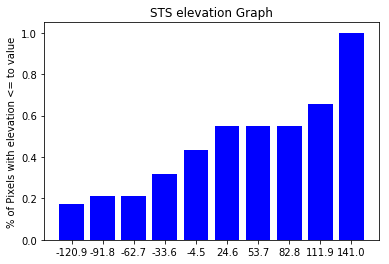

In [12]:
bin_vals = elevation_bins
bin_amts = np.cumsum(np.sum(np.sum(amounts, axis=1), axis=1))
plt.bar(np.arange(n_bins), bin_amts, align='center', color='blue')
plt.xticks(np.arange(n_bins), np.around(bin_vals[1:], decimals=1))
plt.ylabel("% of Pixels with elevation <= to value")
plt.title("STS elevation Graph")
plt.show()

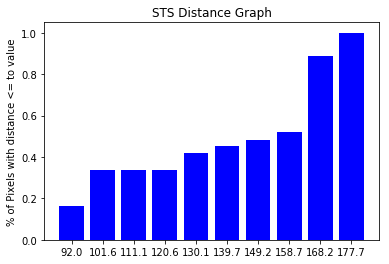

In [13]:
bin_vals = distance_bins
bin_amts = np.cumsum(np.sum(np.sum(amounts, axis=2), axis=0))
plt.bar(np.arange(n_bins), bin_amts, align='center', color='blue')
plt.xticks(np.arange(n_bins), np.around(bin_vals[1:], decimals=1))
plt.ylabel("% of Pixels with distance <= to value")
plt.title("STS Distance Graph")
plt.show()

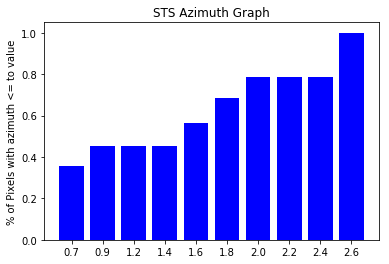

In [14]:
bin_vals = azimuth_bins
bin_amts = np.cumsum(np.sum(np.sum(amounts, axis=1), axis=0))
plt.bar(np.arange(n_bins), bin_amts, align='center', color='blue')
plt.xticks(np.arange(n_bins), np.around(bin_vals[1:], decimals=1))
plt.ylabel("% of Pixels with azimuth <= to value")
plt.title("STS Azimuth Graph")
plt.show()